## Replicating Explanation and Use of Uncertainty Quantified by Bayesian Neural Network Classifiers for Breast Histopathology Images

This notebook documents an experimental replication of the research presented in the paper titled `Explanation and Use of Uncertainty Quantified by Bayesian Neural Network Classifiers for Breast Histopathology Images,` which investigated breast histopathology image classification using a Bayesian CNN approach. The specific experiment replicated here compares the classification performance of three models:

*   TL-CNN: This model employs a VGG-16 architecture.
*   bayesian-CNN: This is the original Bayesian CNN model presented in the paper.
*   modified bayesian-CNN: This is the authors' proposed improvement to the original Bayesian CNN model.



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

## Data Preparation

The experiment utilizes a publicly available breast histopathology image dataset from Kaggle, titled `Breast Histopathology Images` by Paul Mooney (2017). 

**Note : Due to ram limitation, the data limited into about 7000 images each classes**

In [2]:
data_dir =r".\B Histopatology Data"
os.listdir(data_dir)

['cancer', 'normal']

## Image preprocessing

The images have a dimension of `3 x 50 x 50 (Depth x Height x Width)` and are converted to the uint8 format. `Pixel-wise` normalization is performed using a method from OpenCV.

The dataset consists of two classes : cancer (1) and normal (0). By using `80% - 20%` data splitted into `train and validation`

In [3]:
def normalize_and_complement(x):
    x = x.astype('float64')
    return (255 - x) / 255.0

In [4]:
train_datagen = ImageDataGenerator(
                preprocessing_function=normalize_and_complement,
                validation_split = 0.2
                )

In [5]:
train_dt_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'training',
)

validation_dt_generator= train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'validation'
)

Found 12295 images belonging to 2 classes.
Found 3072 images belonging to 2 classes.


### TL-CNN

The architecture of `TL-CNN` followed `VGG-16` and used the weight of `VGG-16` pre-trained on the `ImageNet` dataset for classification and performed `transfer learning` to classify the histopathological data.

Based on paper, there were some strategies to solve the over-fitting from TL-CNN:
1. The use of L1 Regularization
2. The use of Dropout 
3. The use of early st**opping (N**ot Use)
4. The use of cross-validation t**raining (**Not Use)

In [6]:
pretrained = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (50,50,3))

In [7]:
for layer in pretrained.layers:
    layer.trainable = False

In [8]:
## TL_CNN (VGG-16 Architecture)
models = tf.keras.models.Sequential ([

    pretrained,
      
    # Fully Connected Layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')

])

In [9]:
models.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [12]:
models.fit(train_dt_generator,
            epochs=60,
            batch_size =64,
            validation_data=validation_dt_generator,
            )

Epoch 1/60

385/385 [==============================] - 136s 350ms/step - loss: 12.6575 - accuracy: 0.6296 - val_loss: 2.9714 - val_accuracy: 0.5837
Epoch 2/60
385/385 [==============================] - 130s 337ms/step - loss: 2.9165 - accuracy: 0.7120 - val_loss: 2.9897 - val_accuracy: 0.5830
Epoch 3/60
385/385 [==============================] - 133s 344ms/step - loss: 2.8988 - accuracy: 0.7319 - val_loss: 2.9520 - val_accuracy: 0.6670
Epoch 4/60
385/385 [==============================] - 137s 356ms/step - loss: 2.8924 - accuracy: 0.7329 - val_loss: 2.9491 - val_accuracy: 0.6533
Epoch 5/60
385/385 [==============================] - 133s 346ms/step - loss: 2.9013 - accuracy: 0.7363 - val_loss: 2.9731 - val_accuracy: 0.6208
Epoch 6/60
385/385 [==============================] - 132s 343ms/step - loss: 2.8779 - accuracy: 0.7405 - val_loss: 3.0007 - val_accuracy: 0.6250
Epoch 7/60
385/385 [==============================] - 132s 343ms/step - loss: 2.8909 - accuracy: 0.7404 - val_loss: 2.9837

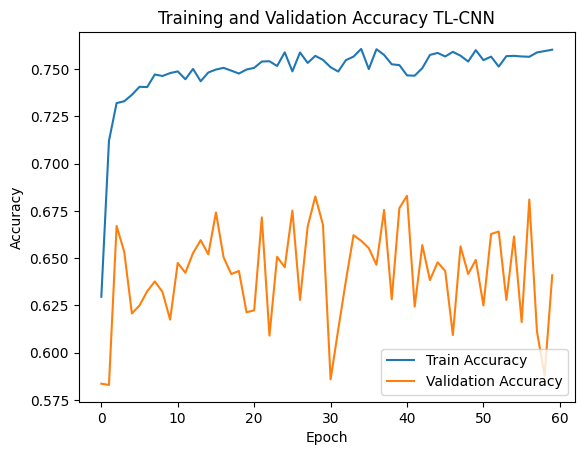

In [14]:
plt.plot(models.history.history['accuracy'], label='Train Accuracy')
plt.plot(models.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy TL-CNN')
plt.legend()
plt.savefig('Acc Graph TLCNN.jpg', dpi = 600)
plt.show()


### Bayesian-CNN  

All convolution layers are fixed as `(3 x 3)` with `stride = 1` and max pool layers are `(2 x 2)` with `stride = 2`

In [11]:
bayesian_cnn = tf.keras.models.Sequential ([
    #block 1
    tfp.layers.Convolution2DFlipout(16, (3,3), activation ='relu', input_shape=(50,50,3), strides = 1), #input
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #block 2
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(32, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

    #block 3
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(256, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #Fully Connected
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(512, activation = 'relu'), #FC1
    tfp.layers.DenseFlipout(2, activation ='sigmoid') # Output
        ])

In [12]:
bayesian_cnn.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [13]:
train_dt_generator = train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'training',
)

validation_dt_generator= train_datagen.flow_from_directory(
    data_dir,
    shuffle=True,
    target_size=(50,50),
    subset= 'validation'
)

Found 12295 images belonging to 2 classes.
Found 3072 images belonging to 2 classes.


In [14]:
bayesian_cnn.fit(train_dt_generator,
            epochs=60,
            batch_size =128,
            validation_data=validation_dt_generator,
            )

Epoch 1/60

385/385 [==============================] - 26s 62ms/step - loss: 1230677.3750 - accuracy: 0.5757 - val_loss: 1132639.3750 - val_accuracy: 0.5055
Epoch 2/60
385/385 [==============================] - 18s 47ms/step - loss: 1037326.8125 - accuracy: 0.4974 - val_loss: 942239.4375 - val_accuracy: 0.5003
Epoch 3/60
385/385 [==============================] - 19s 48ms/step - loss: 850102.1250 - accuracy: 0.5031 - val_loss: 759170.8125 - val_accuracy: 0.5179
Epoch 4/60
385/385 [==============================] - 18s 48ms/step - loss: 672170.3125 - accuracy: 0.5009 - val_loss: 586900.0625 - val_accuracy: 0.4984
Epoch 5/60
385/385 [==============================] - 19s 50ms/step - loss: 507074.0938 - accuracy: 0.4996 - val_loss: 430040.3438 - val_accuracy: 0.5029
Epoch 6/60
385/385 [==============================] - 18s 47ms/step - loss: 360303.4062 - accuracy: 0.5068 - val_loss: 293993.8750 - val_accuracy: 0.4919
Epoch 7/60
385/385 [==============================] - 18s 45ms/step - lo

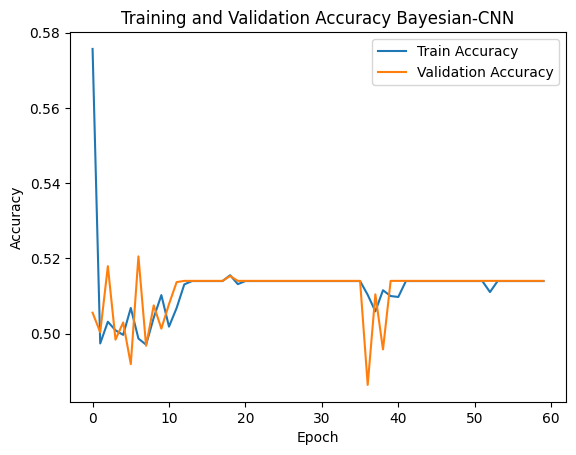

In [15]:
plt.plot(bayesian_cnn.history.history['accuracy'], label='Train Accuracy')
plt.plot(bayesian_cnn.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Bayesian-CNN')
plt.legend()
plt.savefig('Acc Graph Bayesian-CNN.jpg', dpi = 600)
plt.show()

### Modified Bayesian-CNN  

In Fully Connected Layer 1, instead of using ReLU, it uses a stochastic-adaptive ReLU

In [16]:
alpha = tf.Variable(initial_value=0.1, trainable = True)

def stochastic_adaptive_relu(x, alpha):
    f_k = x
    return alpha * f_k * tf.cast(f_k > 0, dtype=tf.float32)

In [17]:
class CustomDense(tfp.layers.DenseFlipout):
    def __init__ (self, units, **kwargs):
        super(CustomDense, self).__init__(units, **kwargs)

    def call(self, inputs):
        output = super(CustomDense, self).call(inputs)
        return stochastic_adaptive_relu(output, alpha)

In [18]:
modified_bayesian_cnn = tf.keras.models.Sequential ([
    #block 1
    tfp.layers.Convolution2DFlipout(32, (3,3), activation ='relu', input_shape=(50,50,3), strides = 1), #input
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #block 2
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(64, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),

    #block 3
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.Conv2D(128, (3,3), activation ='relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),    

    #Fully Connected
    tf.keras.layers.Flatten(),
    CustomDense(256), #FC1 with Stochastic-Adaptive Learning ReLU Activation Function
    tfp.layers.DenseFlipout(2, activation ='sigmoid') # Output
        ])

C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\pre-screening\lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\pre-screening\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
C:\Users\Andreas Sahir\AppData\Local\anaconda3\envs\pre-screening\lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` met

In [19]:
modified_bayesian_cnn.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [20]:
modified_bayesian_cnn.fit(train_dt_generator,
            epochs=60,
            batch_size =64,
            validation_data=validation_dt_generator,
            )

Epoch 1/60
385/385 [==============================] - 20s 47ms/step - loss: 332562.1562 - accuracy: 0.6659 - val_loss: 329946.0000 - val_accuracy: 0.7546
Epoch 2/60
385/385 [==============================] - 17s 45ms/step - loss: 327388.9688 - accuracy: 0.7119 - val_loss: 324831.9062 - val_accuracy: 0.7406
Epoch 3/60
385/385 [==============================] - 16s 41ms/step - loss: 322315.6875 - accuracy: 0.7057 - val_loss: 319795.5938 - val_accuracy: 0.7438
Epoch 4/60
385/385 [==============================] - 16s 42ms/step - loss: 317299.5312 - accuracy: 0.6749 - val_loss: 314805.5938 - val_accuracy: 0.7246
Epoch 5/60
385/385 [==============================] - 15s 39ms/step - loss: 312328.8438 - accuracy: 0.6498 - val_loss: 309846.4062 - val_accuracy: 0.6771
Epoch 6/60
385/385 [==============================] - 16s 41ms/step - loss: 307386.1250 - accuracy: 0.6077 - val_loss: 304912.5000 - val_accuracy: 0.6338
Epoch 7/60
385/385 [==============================] - 17s 43ms/step - loss: 

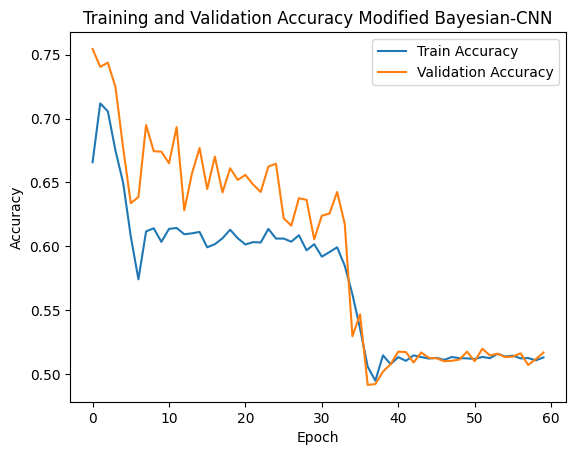

In [21]:
plt.plot(modified_bayesian_cnn.history.history['accuracy'], label='Train Accuracy')
plt.plot(modified_bayesian_cnn.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Modified Bayesian-CNN')
plt.legend()
plt.savefig('Acc Graph Modified Bayesian-CNN.jpg', dpi = 600)
plt.show()